In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import scipy
import pickle
import warnings
import bidict
import collections

import sys
sys.path.append('..')
from construct_graph.graph import Graph, Flat
import construct_graph
import solve_laplace_operator

import sparseqr

from IPython.display import display, HTML

display(HTML("""
<style>
.jp-OutputArea-output {max-width: 100% !important;}
.jp-Cell-outputWrapper {max-width: 100% !important;}
.jp-OutputArea-output pre {max-width: 100% !important;}
</style>
"""))

def calculate_pde_eigenvalues(m, n):
    a = 1 / 2 
    return np.sqrt(((2 * np.pi * m)**2 + (2 * np.pi * n)**2) * a)

In [ ]:
class super_G:
    # need:
    #   - V_coords
    #   - num_Vs
    #   - wadjacency_matrix
    #   - periodic_edges

    def __init__(self, V_coords):
        pass

In [2]:
class Renormalization:

    def __init__(self, g, num_patches_per_dim, autoplot=True):

        self.g = g
        self.num_patches_per_dim = num_patches_per_dim
        self.num_patches = self.num_patches_per_dim**2
        self.patch_side_length = 1.0 / self.num_patches_per_dim
        self.translations = np.array([self.patch_side_length, self.patch_side_length])

        self.super_V_coords, self.patch_coords, self.V_to_super_V = self.partition_graph()
        self.E_data = self.construct_E_data()

        if autoplot:
            self.plot_patching(figsize=5)

    def __call__(self, calculation="full"):#, return_alphas=False):

        if calculation == "full":

            alpha_x, alpha_y = self.solve_for_bilinear_coefficients()

            Q = [np.zeros((2, 2)) for _ in range(self.num_patches)]
            T = [0 for _ in range(self.num_patches)]

            for v, w in self.E_data:
                
                l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]
                alpha_v = np.array([alpha_x[v], alpha_y[v]])
                alpha_w = np.array([alpha_x[w], alpha_y[w]])
                fac = (r_ij + alpha_w - alpha_v)
                T[self.V_to_super_V[v]["patch_num"]] += l_vw
                Q[self.V_to_super_V[v]["patch_num"]] += fac[:, None] @ fac[None, :] / l_vw

        return Q, T
    
    def construct_super_g(self):

        
    
    def solve_for_bilinear_coefficients(self):

        C = scipy.sparse.lil_matrix((self.g.num_Vs + 1, self.g.num_Vs))
        Dx = np.zeros(self.g.num_Vs + 1)
        Dy = np.zeros(self.g.num_Vs + 1)
        
        for v, w in self.E_data:

            l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]

            C[v, w] -= 1 / l_vw
            C[v, v] += 1 / l_vw

            Dx[v] += r_ij[0] / l_vw
            Dy[v] += r_ij[1] / l_vw

        C[-1] = np.ones(self.g.num_Vs)
        C = scipy.sparse.csc_matrix(C)

        alpha_x = scipy.sparse.linalg.lsqr(C, Dx)[0] 
        alpha_y = scipy.sparse.linalg.lsqr(C, Dy)[0]

        return alpha_x, alpha_y

    def partition_graph(self):
        
        super_V_coords = []
        V_to_super_V = {}
        super_V_to_V = collections.defaultdict(list)
        patch_coords = []

        # Create the patch_coords
        for row in range(self.num_patches_per_dim):
            for col in range(self.num_patches_per_dim):
                center_x = (col + 0.5) * self.patch_side_length
                center_y = (row + 0.5) * self.patch_side_length
                patch_coords.append([center_x, center_y])
        patch_coords = np.array(patch_coords)

        # Assign each vertex to the corresponding patch
        for v_num, (x, y) in enumerate(self.g.V_coords):
            patch_col = np.floor(x / self.patch_side_length).astype(int)
            patch_row = np.floor(y / self.patch_side_length).astype(int)
            patch_num = patch_row * self.num_patches_per_dim + patch_col
            V_to_super_V[v_num] = {"patch_num": patch_num, 
                                   "patch_indices": np.array([patch_col, patch_row])}
            super_V_to_V[patch_num].append(v_num)
            
        # Create super_V_coords
        super_V_coords = []
        for patch_num in range(self.num_patches):
            super_V_coords.append(np.mean(self.g.V_coords[super_V_to_V[patch_num]], axis=0))
        super_V_coords = np.array(super_V_coords)  

        self.super_V_to_V = super_V_to_V      

        return super_V_coords, patch_coords, V_to_super_V
    
    def construct_E_data(self):

        E_data = {}

        for v, w in zip(*self.g.wadjacency_matrix.nonzero()):
            E_data[v, w] = {"l_vw": self.g.wadjacency_matrix[v, w]}

            if (v, w) in self.g.periodic_edges or (w, v) in self.g.periodic_edges: 

                i_index = self.V_to_super_V[v]["patch_indices"].copy()
                j_index = self.V_to_super_V[w]["patch_indices"].copy()
                ji_ind_dif = j_index - i_index
                patch_i_coords = self.super_V_coords[self.V_to_super_V[v]["patch_num"]].copy()
                patch_j_coords = self.super_V_coords[self.V_to_super_V[w]["patch_num"]].copy()

                if ji_ind_dif[0] == self.num_patches_per_dim - 1:
                    patch_j_coords[0] -= 1
                elif ji_ind_dif[0] == -(self.num_patches_per_dim - 1):
                    patch_j_coords[0] += 1
                if ji_ind_dif[1] == self.num_patches_per_dim - 1:
                    patch_j_coords[1] -= 1
                elif ji_ind_dif[1] == -(self.num_patches_per_dim - 1):
                    patch_j_coords[1] += 1

                r_ij = patch_j_coords - patch_i_coords

            else:
                i_num, j_num = self.V_to_super_V[v]["patch_num"], self.V_to_super_V[w]["patch_num"]
                r_ij = self.super_V_coords[j_num] - self.super_V_coords[i_num]

            E_data[v, w]["r_ij"] = r_ij

        return E_data
    
    def plot_patching(self, figsize=10, linewidth=2,
                      return_figax=False, plot_V_nums=False):

        fig, ax = self.g.plot_graph(return_figax=True, figsize=figsize, linewidth=linewidth)
        for center in self.patch_coords:
            bottom_corner = (center[0] - self.patch_side_length / 2, center[1] - self.patch_side_length / 2)
            square = matplotlib.patches.Rectangle(bottom_corner, self.patch_side_length, self.patch_side_length,
                                                  linewidth=2 * linewidth, 
                                                  edgecolor='r', facecolor=(0.8, 0.8, 0.8, 0.1), alpha=1)
            ax.add_patch(square)
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)

        if plot_V_nums:
            for v_num, v_coord in enumerate(self.g.V_coords):
                ax.annotate(str(v_num), v_coord, fontsize=20)

        if return_figax:
            return fig, ax
        plt.show()

In [3]:
calculate_eigenvalues = False
N = 1
np.random.seed(6)
num_Vs_for_tile = 100000
g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
                                  num_Vs_for_tile=num_Vs_for_tile, 
                                  num_horizontal_displacements=N, 
                                  num_vertical_displacements=N,
                                  autoplot=False, figsize=5)
# g.plot_graph(figsize=3, linewidth=1, capstyle=False)

if calculate_eigenvalues:
    guesses = np.linspace(3.5, 5, 50)
    eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
    ks = eigs(guesses, printerval=1, max_steps=1000, tol=1e-12, solve_type="SVD iterate")
    _, index = np.unique(np.round(ks, 6), return_index=True)
    eigenvalues = ks[index]
    print(np.mean(eigenvalues) / calculate_pde_eigenvalues(1, 0))
    print(eigenvalues / calculate_pde_eigenvalues(1, 0))

In [49]:
num_patches_per_dim = 30
R = Renormalization(g, num_patches_per_dim=num_patches_per_dim, autoplot=False)
# R.plot_patching(plot_V_nums=False, figsize=5)
Q, T = R()
QQ = np.mean([i / j for i, j in zip(Q, T)], axis=0)
print(np.trace(QQ))

0.9288368607198318


In [4]:
QQ = []

for num_patches_per_dim in range(3, 50):
    print(num_patches_per_dim)
    R = Renormalization(g, num_patches_per_dim=num_patches_per_dim, autoplot=False)
    Q, T = R()
    QQ.append(np.trace(np.mean([i / j for i, j in zip(Q, T)], axis=0)))

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [9]:
mean_num_Vs_per_patch = g.num_Vs / np.arange(3, 50)**2

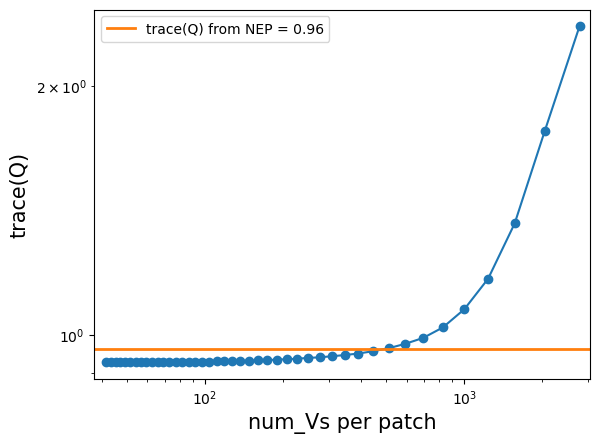

In [48]:
truncate = 3
plt.loglog(mean_num_Vs_per_patch[truncate:], QQ[truncate:], 'o-')
plt.plot([0, 5e4],[0.96, 0.96], linewidth=2, label="trace(Q) from NEP = 0.96")
plt.xlim(0.9*np.min(mean_num_Vs_per_patch[truncate:]), 1.1*np.max(mean_num_Vs_per_patch[truncate:]))
plt.xlabel("num_Vs per patch", fontsize=15)
plt.ylabel("trace(Q)", fontsize=15)
plt.legend()
plt.show()

In [49]:
# data = {"info": "seed=6, num_Vs=1e5 for uniformly_random_Delaunay_triangulated", "num_patches_per_dim": np.arange(3, 50), "trace(Q)": QQ}